In [1]:
!pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
Looking in links: https://download.pytorch.org/whl/torch_stable.html
  Using cached https://download.pytorch.org/whl/cu111/torch-1.9.0%2Bcu111-cp37-cp37m-linux_x86_64.whl (2041.3 MB)
  Using cached https://download.pytorch.org/whl/cu111/torchvision-0.10.0%2Bcu111-cp37-cp37m-linux_x86_64.whl (23.2 MB)
  Using cached torchaudio-0.9.0-cp37-cp37m-manylinux1_x86_64.whl (1.9 MB)
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [2]:
!pip install transformers

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
  Using cached transformers-4.10.0-py3-none-any.whl (2.8 MB)
  Using cached sacremoses-0.0.45-py3-none-any.whl (895 kB)
  Using cached regex-2021.8.28-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (745 kB)
  Using cached tokenizers-0.10.3-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (3.3 MB)
  Using cached huggingface_hub-0.0.16-py3-none-any.whl (50 kB)
  Using cached packaging-21.0-py3-none-any.whl (40 kB)
  Attempting uninstall: packaging
    Found existing installation: packaging 20.1
    Uninstalling packaging-20.1:
  

In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

In [4]:
torch.__version__

'1.9.0+cu111'

In [5]:
df = pd.read_csv('../data/amazon_large_stratified.csv')

In [6]:
df['review_sentiments'].value_counts()

1    500000
0    500000
Name: review_sentiments, dtype: int64

In [7]:
train_texts, temp_texts, train_labels, temp_labels = train_test_split(df['review'].tolist(), 
                                                                      df['review_sentiments'].tolist(), 
                                                                      stratify=df['review_sentiments'].tolist(), 
                                                                      test_size=0.5, 
                                                                      random_state=42)

In [8]:
val_texts, test_texts, val_labels, test_labels = train_test_split(temp_texts, 
                                                                  temp_labels, 
                                                                  stratify=temp_labels, 
                                                                  test_size=250000, 
                                                                  random_state=42)

In [9]:
print(len(train_labels), len(val_labels), len(test_labels))

500000 250000 250000


In [10]:
print(len(train_texts), len(val_texts), len(test_texts))

500000 250000 250000


In [11]:
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

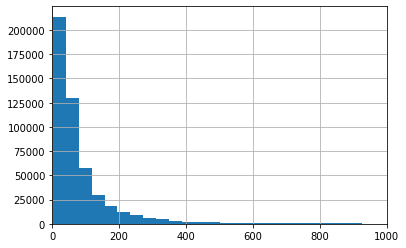

In [12]:
seq_len = [len(i.split()) for i in train_texts]
import matplotlib.pyplot as plt
pd.Series(seq_len).hist(bins = 200)
plt.xlim((0, 1000))
plt.show()

In [13]:
train_encodings = tokenizer(train_texts, truncation=True, 
                            padding=True, max_length = 200)
val_encodings = tokenizer(val_texts, truncation=True, 
                          padding=True, max_length = 200)
test_encodings = tokenizer(test_texts, truncation=True, 
                           padding=True, max_length = 200)

In [14]:
class AmazonReviewsDatasetSmall(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = AmazonReviewsDatasetSmall(train_encodings, train_labels)
val_dataset = AmazonReviewsDatasetSmall(val_encodings, val_labels)
test_dataset = AmazonReviewsDatasetSmall(test_encodings, test_labels)

In [ ]:
print(len(train_labels), len(val_labels), len(test_labels))

In [ ]:
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset             # evaluation dataset
)

trainer.train()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'pre_classi

Step,Training Loss
10,0.698100
20,0.688500
30,0.698500
40,0.683900
50,0.686200
60,0.686200
70,0.670900
80,0.654000
90,0.600300
100,0.558100


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1500
Configuration saved in ./results/checkpoint-1500/config.json
Model weights saved in ./results/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-2000
Configuration saved in ./results/checkpoint-2000/config.json
Model weights saved in ./results/checkpoint-2000/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-2500
Configuration saved in ./results/checkpoint-2500/config.json
Model weights saved in ./results/checkpoint-2500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-3000
Configuration saved in ./results/checkpoint-3

In [4]:
torch.save(trainer.model.state_dict(), distillbert_large_saved_weights)

NameError: name 'torch' is not defined